**Progressive Self-Supervised Denoising using Noise2Void Variants: A Cascading Approach**

Noise2Void Variant 1 – Single Noisy Image Training (Original N2V)
This script demonstrates the classic Noise2Void (N2V) approach. It trains a small U-Net on a single noisy image using a center-pixel masking strategy, with no clean target image required. This is the earliest and simplest version of N2V.

▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise (1).png to slice&#x3a_3309_gaussian_noise (1).png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise (1).png
noisy shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | N2V-loss=0.01867
epoch 10/10 | N2V-loss=0.00424


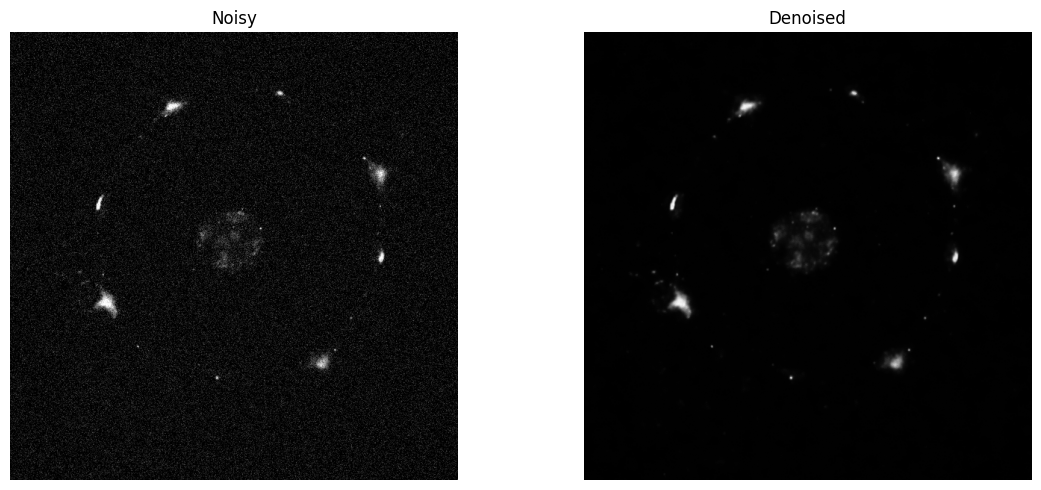


⬆️  If you have a *clean* reference, upload it now (else skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309 (1).tif
✓ clean loaded: slice&#x3a_3309 (1).tif

📊  Metrics vs. clean reference
    • MSE  : 0.001079
    • PSNR : 29.67 dB
    • SSIM : 0.6088


In [2]:
# ============================================================
#  Noise2Void Variant 1  –  Single-Noisy-Image Training Script

#  ▸ now prints PSNR, SSIM, MSE if you provide a clean image
# ============================================================

# — 0. install extras ---------------------------------------------------
!pip -q install tifffile scikit-image       # tifffile for .tif, skimage for PSNR/SSIM

# — 1. imports & device -------------------------------------------------
import os, random, math, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from google.colab import files
from PIL import Image
import tifffile
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# — 2. upload NOISY image ----------------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]           # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("noisy shape:", noisy_np.shape)

# — 3. patch dataset ----------------------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=12000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8,
                      shuffle=True, num_workers=2, pin_memory=True)

# — 4. centre-pixel masking --------------------------------------------
def mask_center(x, p=0.03):
    m = torch.rand_like(x) < p
    shifts = [(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    idx = torch.randint(0, len(shifts), (x.size(0),1,x.size(2),x.size(3)), device=x.device)
    nb  = torch.zeros_like(x)
    for k,(dy,dx) in enumerate(shifts):
        nbk = torch.roll(x, (dy,dx), dims=(-2,-1))
        nb[idx==k] = nbk[idx==k]
    x_m = x.clone(); x_m[m] = nb[m]
    return x_m, m

# — 5. tiny U-Net -------------------------------------------------------
class ConvBlk(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.LeakyReLU(0.1,True),
            nn.Conv2d(c2,c2,3,padding=1), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class UNetSmall(nn.Module):
    def __init__(self, ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = ConvBlk(ch,base), ConvBlk(base,base*2), ConvBlk(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = ConvBlk(base*4+base*2,base*2), ConvBlk(base*2+base,base)
        self.out = nn.Conv2d(base, ch, 1)
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = UNetSmall().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# — 6. training ---------------------------------------------------------
epochs = 10
opt    = optim.Adam(net.parameters(), lr=1e-3)
sched  = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); tot = 0
    for xb in train_dl:
        xb = xb.to(device)
        xin, m = mask_center(xb, p=0.035)
        loss = F.mse_loss(net(xin)[m], xb[m])
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | N2V-loss={tot/len(train_dl.dataset):.5f}")

# — 7. denoise full image ---------------------------------------------
net.eval()
with torch.no_grad():
    den = net(torch.from_numpy(noisy_np).unsqueeze(0).to(device)).cpu().squeeze().numpy()

# — 8. show before / after --------------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(noisy_np.squeeze(), cmap='gray'); plt.title("Noisy");   plt.axis('off')
plt.subplot(1,2,2); plt.imshow(den,            cmap='gray'); plt.title("Denoised"); plt.axis('off')
plt.tight_layout(); plt.show()

# — 9. OPTIONAL: upload CLEAN image → print metrics --------------------
print("\n⬆️  If you have a *clean* reference, upload it now (else skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()

    # align sizes if necessary
    if clean_np.shape != den.shape:
        print(f"(Resizing clean from {clean_np.shape} → {den.shape})")
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=den.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()

    mse_val  = np.mean((den - clean_np)**2)
    psnr_val = psnr(clean_np, den, data_range=1.0)
    ssim_val = ssim(clean_np, den, data_range=1.0)

    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference provided → metrics skipped.")


Noise2Void Variant 2 – Blind-Spot CNN (Ω-Network)
This implementation of Blind-Spot Noise2Void trains a CNN that learns to denoise a noisy image by avoiding self-reference — it never sees the center pixel during prediction. It uses a blind-spot convolution, combined with Ω-rotation averaging, for more robust and directionally invariant denoising.

▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise (1).png to slice&#x3a_3309_gaussian_noise (1) (1).png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise (1) (1).png
image shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | loss=0.00018
epoch 10/10 | loss=0.00210


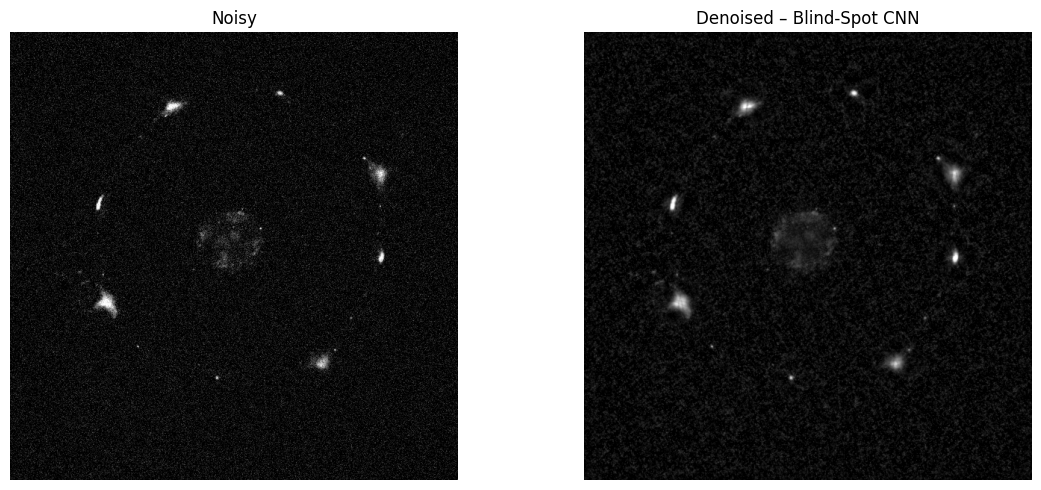


⬆️  Upload a *clean* image for PSNR / SSIM / MSE (or skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309 (2).tif
✓ clean loaded: slice&#x3a_3309 (2).tif

📊  Metrics vs. clean reference
    • MSE  : 0.002670
    • PSNR : 25.73 dB
    • SSIM : 0.2841


In [4]:
# ============================================================
#  Noise2Void Variant 2 – Blind-Spot CNN (Ω-network version)
#  ▸ Longer training + proper display scaling
#  ▸ Prints PSNR / SSIM / MSE if clean image is provided
# ============================================================

# 0 ▸ install extras ----------------------------------------------------
!pip -q install tifffile scikit-image
import tifffile
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim

# 1 ▸ imports & device --------------------------------------------------
import numpy as np, matplotlib.pyplot as plt, torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from google.colab import files

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# 2 ▸ upload NOISY image -----------------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]          # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("image shape:", noisy_np.shape)

# 3 ▸ patch dataset -----------------------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=16000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8, shuffle=True,
                      num_workers=2, pin_memory=True)

# 4 ▸ blind-spot layers -------------------------------------------------
class BlindSpotConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.pad  = nn.ConstantPad2d((1,1,2,0), 0)   # L,R,T,B
        self.conv = nn.Conv2d(in_c, out_c, 3, padding=0)
    def forward(self,x): return self.conv(self.pad(x))

class BSBlock(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            BlindSpotConv(c1,c2), nn.LeakyReLU(0.1,True),
            BlindSpotConv(c2,c2), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class BlindSpotUNet(nn.Module):
    def __init__(self, ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = BSBlock(ch,base), BSBlock(base,base*2), BSBlock(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = BSBlock(base*4+base*2,base*2), BSBlock(base*2+base,base)
        self.out = nn.Conv2d(base, ch, 1)
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = BlindSpotUNet().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# 5 ▸ Ω-forward (rotate-average) ---------------------------------------
def omega_fwd(model,x):
    outs=[]
    for k in range(4):
        y = model(torch.rot90(x,k,(-2,-1)))
        outs.append(torch.rot90(y,-k,(-2,-1)))
    return torch.mean(torch.stack(outs,0),0)

# 6 ▸ training ----------------------------------------------------------
epochs = 10                    # ← longer than before
opt    = optim.Adam(net.parameters(), lr=1e-3)
sched  = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); run=0
    for xb in train_dl:
        xb = xb.to(device)
        loss = F.mse_loss(omega_fwd(net, xb), xb)
        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | loss={run/len(train_dl.dataset):.5f}")

# 7 ▸ denoise full image -----------------------------------------------
net.eval()
with torch.no_grad():
    den = omega_fwd(net, torch.from_numpy(noisy_np).unsqueeze(0).to(device)).cpu().squeeze().numpy()
    den = np.clip(den, 0, 1)

# 8 ▸ show before / after ----------------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(noisy_np.squeeze(), cmap='gray', vmin=0, vmax=1); plt.title("Noisy");   plt.axis('off')
plt.subplot(1,2,2); plt.imshow(den,            cmap='gray', vmin=0, vmax=1); plt.title("Denoised – Blind-Spot CNN"); plt.axis('off')
plt.tight_layout(); plt.show()

# 9 ▸ OPTIONAL metrics --------------------------------------------------
print("\n⬆️  Upload a *clean* image for PSNR / SSIM / MSE (or skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()

    if clean_np.shape != den.shape:
        print(f"(Resizing clean {clean_np.shape} → {den.shape})")
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=den.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()

    mse_val  = np.mean((den - clean_np)**2)
    psnr_val = psnr(clean_np, den, data_range=1.0)
    ssim_val = ssim(clean_np, den, data_range=1.0)

    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference supplied → metrics skipped.")


Apply Structured Noise2Void with a grid-based masking strategy (step = 5), using a U-Net to denoise a noisy grayscale image. This is your 1st pass of denoising.

▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise.png to slice&#x3a_3309_gaussian_noise.png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise.png
image shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | loss=0.00058
epoch 10/10 | loss=0.00078
denoised saved → slice&#x3a_3309_gaussian_noise_denoised.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mask saved → slice&#x3a_3309_gaussian_noise_gridmask.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

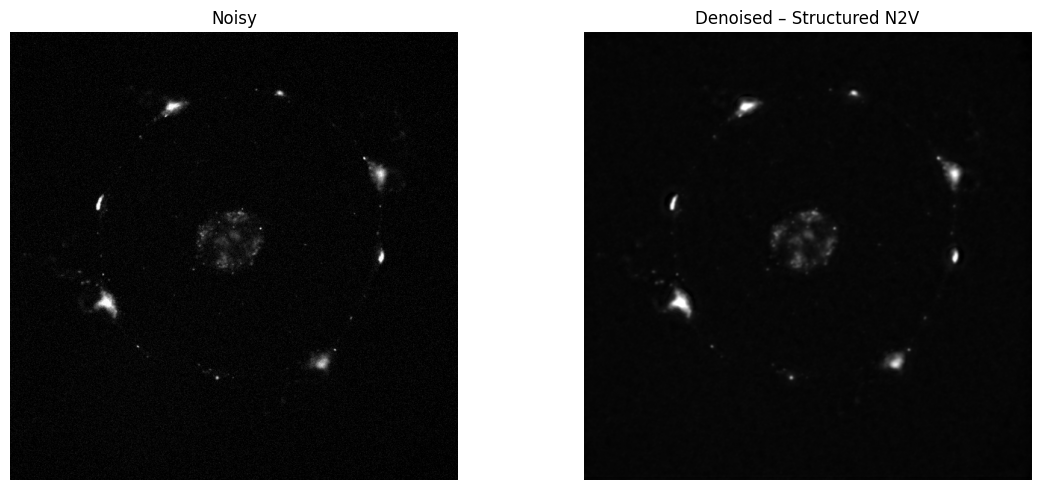


⬆️  Upload *clean* image for PSNR / SSIM / MSE (or skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309.tif
✓ clean loaded: slice&#x3a_3309.tif

📊  Metrics vs. clean reference
    • MSE  : 0.000254
    • PSNR : 35.95 dB
    • SSIM : 0.8449


In [ ]:
# ============================================================
#  Noise2Void Variant 3 – Structured/Grid‑Mask Self‑Supervised
#  ▸ bug‑fixed grid mask
#  ▸ 40 epochs, step = 5
#  ▸ Saves denoised PNG  +  full‑image grid mask TIFF
#  ▸ Optional PSNR / SSIM / MSE against a clean image
# ============================================================

# 0 ▸ install dependencies -----------------------------------
!pip -q install tifffile scikit-image imageio
import tifffile, imageio, os, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim
from google.colab import files

# 1 ▸ imports & device --------------------------------------
import matplotlib.pyplot as plt, torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# 2 ▸ upload noisy image ------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]          # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("image shape:", noisy_np.shape)

# 3 ▸ patch dataset -----------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=40000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8, shuffle=True,
                      num_workers=2, pin_memory=True)

# 4 ▸ grid‑mask helper --------------------------------------
def grid_mask(x, step=5):
    """
    x : (B,C,H,W) tensor
    returns masked_x, mask  (mask is boolean)
    """
    B,C,H,W = x.shape
    off_y = torch.randint(0, step, (B,1,1,1), device=x.device)
    off_x = torch.randint(0, step, (B,1,1,1), device=x.device)
    ys = (torch.arange(H, device=x.device)[None,None,:,None] + off_y) % step == 0
    xs = (torch.arange(W, device=x.device)[None,None,None,:] + off_x) % step == 0
    mask = ys & xs                                    # (B,1,H,W)
    nb   = torch.roll(x, (1,0), (-2,-1))
    x_m  = x.clone(); x_m[mask] = nb[mask]
    return x_m, mask

# 5 ▸ lightweight U‑Net -------------------------------------
class ConvBlk(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.LeakyReLU(0.1,True),
            nn.Conv2d(c2,c2,3,padding=1), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class UNetSmall(nn.Module):
    def __init__(self, ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = ConvBlk(ch,base), ConvBlk(base,base*2), ConvBlk(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = ConvBlk(base*4+base*2,base*2), ConvBlk(base*2+base,base)
        self.out = nn.Conv2d(base, ch, 1)
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = UNetSmall().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# 6 ▸ training ----------------------------------------------
epochs, lr, step = 10, 1e-3, 5
opt = optim.Adam(net.parameters(), lr=lr)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); run=0
    for xb in train_dl:
        xb = xb.to(device)
        xin, m = grid_mask(xb, step=step)
        loss = F.mse_loss(net(xin)[m], xb[m])
        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | loss={run/len(train_dl.dataset):.5f}")

# 7 ▸ denoise full image ------------------------------------
net.eval()
with torch.no_grad():
    den = net(torch.from_numpy(noisy_np).unsqueeze(0).to(device)).cpu().squeeze().numpy()
    den = np.clip(den, 0, 1)

# 8 ▸ save outputs ------------------------------------------
out_png = os.path.splitext(noisy_fname)[0] + "_denoised.png"
imageio.imwrite(out_png, (den*255).astype(np.uint8))
print(f"denoised saved → {out_png}")
files.download(out_png)

# full‑image checkerboard mask
_, full_mask = grid_mask(torch.from_numpy(noisy_np).unsqueeze(0), step=step)
mask_tif = os.path.splitext(noisy_fname)[0] + "_gridmask.tif"
tifffile.imwrite(mask_tif, full_mask.squeeze().numpy().astype(np.uint8))
print(f"mask saved → {mask_tif}")
files.download(mask_tif)

# 9 ▸ display ------------------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(noisy_np.squeeze(), cmap='gray', vmin=0, vmax=1); plt.title("Noisy");   plt.axis('off')
plt.subplot(1,2,2); plt.imshow(den,            cmap='gray', vmin=0, vmax=1); plt.title("Denoised – Structured N2V"); plt.axis('off')
plt.tight_layout(); plt.show()

# 10 ▸ optional metrics -------------------------------------
print("\n⬆️  Upload *clean* image for PSNR / SSIM / MSE (or skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()
    if clean_np.shape != den.shape:
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=den.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()
    mse_val  = np.mean((den - clean_np)**2)
    psnr_val = psnr(clean_np, den, data_range=1.0)
    ssim_val = ssim(clean_np, den, data_range=1.0)
    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference supplied → metrics skipped.")


Train a U-Net denoiser using the Structured Noise2Void (N2V) approach:

Use grid-based masking (step = 5).

Train a model to predict masked pixels from context (self-supervised).

Save the denoised image and (optionally) evaluate against a clean reference.

▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise_denoised (1)_denoised.png to slice&#x3a_3309_gaussian_noise_denoised (1)_denoised (1).png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise_denoised (1)_denoised (1).png
image shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | loss=0.00086
epoch 10/10 | loss=0.00004
denoised saved → slice&#x3a_3309_gaussian_noise_denoised (1)_denoised (1)_denoised.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mask saved → slice&#x3a_3309_gaussian_noise_denoised (1)_denoised (1)_gridmask.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

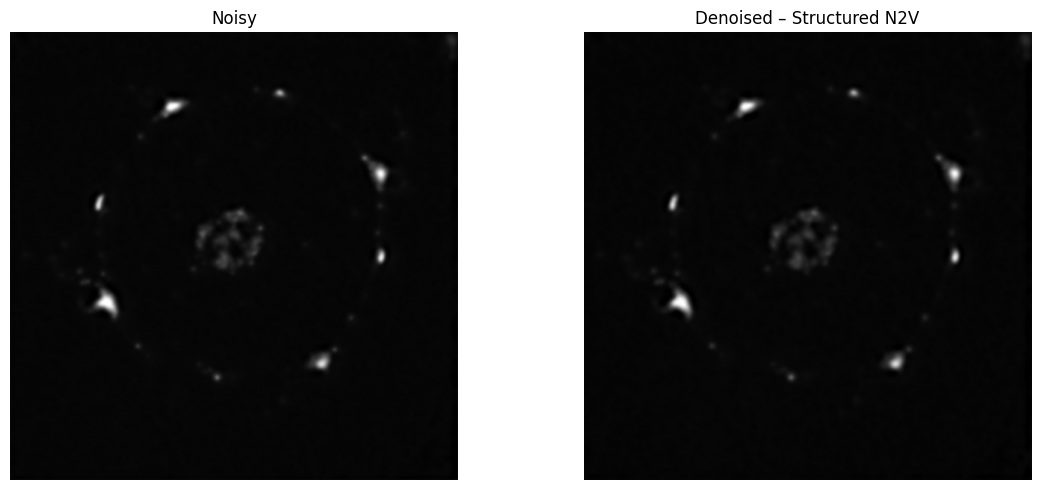


⬆️  Upload *clean* image for PSNR / SSIM / MSE (or skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309 (2).tif
✓ clean loaded: slice&#x3a_3309 (2).tif

📊  Metrics vs. clean reference
    • MSE  : 0.000294
    • PSNR : 35.32 dB
    • SSIM : 0.8970


In [ ]:
# ============================================================
#  Noise2Void Variant 3 – Structured/Grid‑Mask Self‑Supervised
#  ▸ bug‑fixed grid mask
#  ▸ 40 epochs, step = 5
#  ▸ Saves denoised PNG  +  full‑image grid mask TIFF
#  ▸ Optional PSNR / SSIM / MSE against a clean image
# ============================================================

# 0 ▸ install dependencies -----------------------------------
!pip -q install tifffile scikit-image imageio
import tifffile, imageio, os, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim
from google.colab import files

# 1 ▸ imports & device --------------------------------------
import matplotlib.pyplot as plt, torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# 2 ▸ upload noisy image ------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]          # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("image shape:", noisy_np.shape)

# 3 ▸ patch dataset -----------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=40000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8, shuffle=True,
                      num_workers=2, pin_memory=True)

# 4 ▸ grid‑mask helper --------------------------------------
def grid_mask(x, step=5):
    """
    x : (B,C,H,W) tensor
    returns masked_x, mask  (mask is boolean)
    """
    B,C,H,W = x.shape
    off_y = torch.randint(0, step, (B,1,1,1), device=x.device)
    off_x = torch.randint(0, step, (B,1,1,1), device=x.device)
    ys = (torch.arange(H, device=x.device)[None,None,:,None] + off_y) % step == 0
    xs = (torch.arange(W, device=x.device)[None,None,None,:] + off_x) % step == 0
    mask = ys & xs                                    # (B,1,H,W)
    nb   = torch.roll(x, (1,0), (-2,-1))
    x_m  = x.clone(); x_m[mask] = nb[mask]
    return x_m, mask

# 5 ▸ lightweight U‑Net -------------------------------------
class ConvBlk(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.LeakyReLU(0.1,True),
            nn.Conv2d(c2,c2,3,padding=1), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class UNetSmall(nn.Module):
    def __init__(self, ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = ConvBlk(ch,base), ConvBlk(base,base*2), ConvBlk(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = ConvBlk(base*4+base*2,base*2), ConvBlk(base*2+base,base)
        self.out = nn.Conv2d(base, ch, 1)
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = UNetSmall().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# 6 ▸ training ----------------------------------------------
epochs, lr, step = 10, 1e-3, 5
opt = optim.Adam(net.parameters(), lr=lr)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); run=0
    for xb in train_dl:
        xb = xb.to(device)
        xin, m = grid_mask(xb, step=step)
        loss = F.mse_loss(net(xin)[m], xb[m])
        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | loss={run/len(train_dl.dataset):.5f}")

# 7 ▸ denoise full image ------------------------------------
net.eval()
with torch.no_grad():
    den = net(torch.from_numpy(noisy_np).unsqueeze(0).to(device)).cpu().squeeze().numpy()
    den = np.clip(den, 0, 1)

# 8 ▸ save outputs ------------------------------------------
out_png = os.path.splitext(noisy_fname)[0] + "_denoised.png"
imageio.imwrite(out_png, (den*255).astype(np.uint8))
print(f"denoised saved → {out_png}")
files.download(out_png)

# full‑image checkerboard mask
_, full_mask = grid_mask(torch.from_numpy(noisy_np).unsqueeze(0), step=step)
mask_tif = os.path.splitext(noisy_fname)[0] + "_gridmask.tif"
tifffile.imwrite(mask_tif, full_mask.squeeze().numpy().astype(np.uint8))
print(f"mask saved → {mask_tif}")
files.download(mask_tif)

# 9 ▸ display ------------------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(noisy_np.squeeze(), cmap='gray', vmin=0, vmax=1); plt.title("Noisy");   plt.axis('off')
plt.subplot(1,2,2); plt.imshow(den,            cmap='gray', vmin=0, vmax=1); plt.title("Denoised – Structured N2V"); plt.axis('off')
plt.tight_layout(); plt.show()

# 10 ▸ optional metrics -------------------------------------
print("\n⬆️  Upload *clean* image for PSNR / SSIM / MSE (or skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()
    if clean_np.shape != den.shape:
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=den.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()
    mse_val  = np.mean((den - clean_np)**2)
    psnr_val = psnr(clean_np, den, data_range=1.0)
    ssim_val = ssim(clean_np, den, data_range=1.0)
    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference supplied → metrics skipped.")


Structured N2V – 3rd Denoising Pass Summary
The third pass refines the image further by retraining a new U-Net model on the already twice-denoised output. This helps remove any residual or low-intensity noise not captured in earlier passes.

▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise_denoised (1)_denoised (1)_denoised.png to slice&#x3a_3309_gaussian_noise_denoised (1)_denoised (1)_denoised (2).png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise_denoised (1)_denoised (1)_denoised (2).png
image shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | loss=0.00003
epoch 10/10 | loss=0.00014
denoised saved → slice&#x3a_3309_gaussian_noise_denoised (1)_denoised (1)_denoised (2)_denoised.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mask saved → slice&#x3a_3309_gaussian_noise_denoised (1)_denoised (1)_denoised (2)_gridmask.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

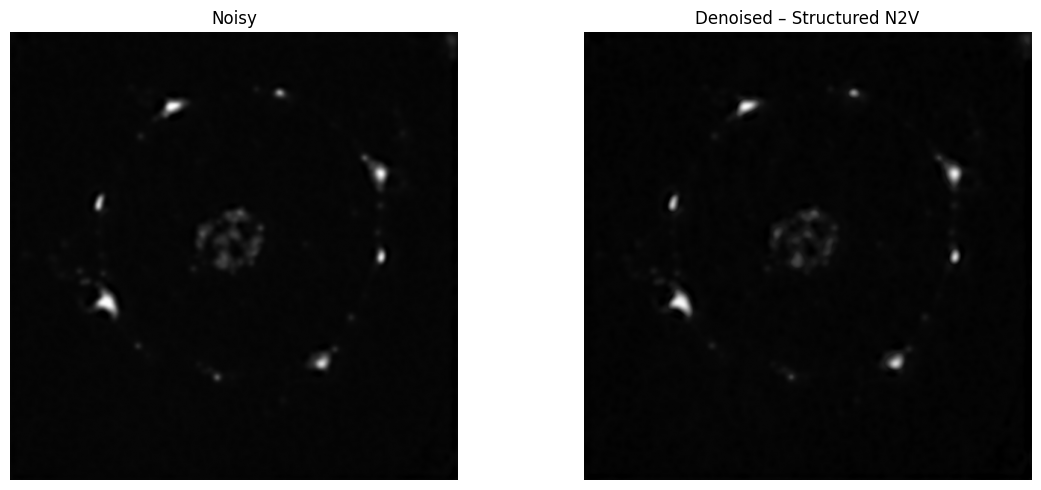


⬆️  Upload *clean* image for PSNR / SSIM / MSE (or skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309 (4).tif
✓ clean loaded: slice&#x3a_3309 (4).tif

📊  Metrics vs. clean reference
    • MSE  : 0.000281
    • PSNR : 35.51 dB
    • SSIM : 0.9315


In [ ]:
# ============================================================
#  Noise2Void Variant 3 – Structured/Grid‑Mask Self‑Supervised
#  ▸ bug‑fixed grid mask
#  ▸ 40 epochs, step = 5
#  ▸ Saves denoised PNG  +  full‑image grid mask TIFF
#  ▸ Optional PSNR / SSIM / MSE against a clean image
# ============================================================

# 0 ▸ install dependencies -----------------------------------
!pip -q install tifffile scikit-image imageio
import tifffile, imageio, os, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim
from google.colab import files

# 1 ▸ imports & device --------------------------------------
import matplotlib.pyplot as plt, torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# 2 ▸ upload noisy image ------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]          # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("image shape:", noisy_np.shape)

# 3 ▸ patch dataset -----------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=40000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8, shuffle=True,
                      num_workers=2, pin_memory=True)

# 4 ▸ grid‑mask helper --------------------------------------
def grid_mask(x, step=5):
    """
    x : (B,C,H,W) tensor
    returns masked_x, mask  (mask is boolean)
    """
    B,C,H,W = x.shape
    off_y = torch.randint(0, step, (B,1,1,1), device=x.device)
    off_x = torch.randint(0, step, (B,1,1,1), device=x.device)
    ys = (torch.arange(H, device=x.device)[None,None,:,None] + off_y) % step == 0
    xs = (torch.arange(W, device=x.device)[None,None,None,:] + off_x) % step == 0
    mask = ys & xs                                    # (B,1,H,W)
    nb   = torch.roll(x, (1,0), (-2,-1))
    x_m  = x.clone(); x_m[mask] = nb[mask]
    return x_m, mask

# 5 ▸ lightweight U‑Net -------------------------------------
class ConvBlk(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.LeakyReLU(0.1,True),
            nn.Conv2d(c2,c2,3,padding=1), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class UNetSmall(nn.Module):
    def __init__(self, ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = ConvBlk(ch,base), ConvBlk(base,base*2), ConvBlk(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = ConvBlk(base*4+base*2,base*2), ConvBlk(base*2+base,base)
        self.out = nn.Conv2d(base, ch, 1)
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = UNetSmall().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# 6 ▸ training ----------------------------------------------
epochs, lr, step = 10, 1e-3, 5
opt = optim.Adam(net.parameters(), lr=lr)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); run=0
    for xb in train_dl:
        xb = xb.to(device)
        xin, m = grid_mask(xb, step=step)
        loss = F.mse_loss(net(xin)[m], xb[m])
        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | loss={run/len(train_dl.dataset):.5f}")

# 7 ▸ denoise full image ------------------------------------
net.eval()
with torch.no_grad():
    den = net(torch.from_numpy(noisy_np).unsqueeze(0).to(device)).cpu().squeeze().numpy()
    den = np.clip(den, 0, 1)

# 8 ▸ save outputs ------------------------------------------
out_png = os.path.splitext(noisy_fname)[0] + "_denoised.png"
imageio.imwrite(out_png, (den*255).astype(np.uint8))
print(f"denoised saved → {out_png}")
files.download(out_png)

# full‑image checkerboard mask
_, full_mask = grid_mask(torch.from_numpy(noisy_np).unsqueeze(0), step=step)
mask_tif = os.path.splitext(noisy_fname)[0] + "_gridmask.tif"
tifffile.imwrite(mask_tif, full_mask.squeeze().numpy().astype(np.uint8))
print(f"mask saved → {mask_tif}")
files.download(mask_tif)

# 9 ▸ display ------------------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(noisy_np.squeeze(), cmap='gray', vmin=0, vmax=1); plt.title("Noisy");   plt.axis('off')
plt.subplot(1,2,2); plt.imshow(den,            cmap='gray', vmin=0, vmax=1); plt.title("Denoised – Structured N2V"); plt.axis('off')
plt.tight_layout(); plt.show()

# 10 ▸ optional metrics -------------------------------------
print("\n⬆️  Upload *clean* image for PSNR / SSIM / MSE (or skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()
    if clean_np.shape != den.shape:
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=den.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()
    mse_val  = np.mean((den - clean_np)**2)
    psnr_val = psnr(clean_np, den, data_range=1.0)
    ssim_val = ssim(clean_np, den, data_range=1.0)
    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference supplied → metrics skipped.")


Probabilistic N2V – 1st Denoising Pass
This code script implements a single-image demo of Probabilistic Noise2Void. Instead of predicting a single value per pixel, the model predicts a mean (μ) and log-variance (log σ²) for each pixel, and uses a Gaussian Negative Log-Likelihood (NLL) loss.

This enables:

Uncertainty modeling

Better denoising under ambiguous noise

A more statistically grounded loss than simple MSE

▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise_Prob.png to slice&#x3a_3309_gaussian_noise_Prob.png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise_Prob.png
image shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | masked‑NLL=-2.35717
epoch 10/10 | masked‑NLL=-2.49960
μ saved → slice&#x3a_3309_gaussian_noise_Prob_denoised.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

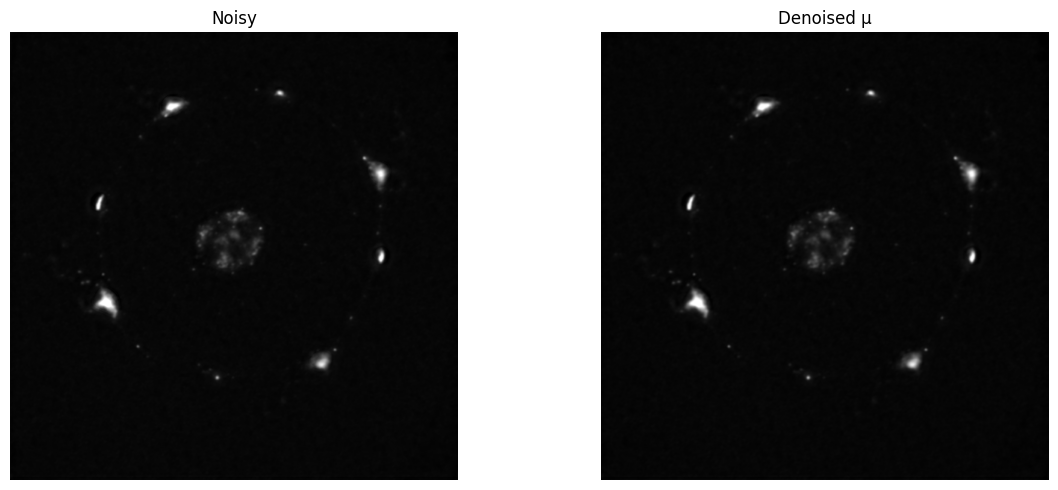


⬆️  Upload *clean* reference for PSNR / SSIM / MSE (or skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309 (5).tif
✓ clean loaded: slice&#x3a_3309 (5).tif

📊  Metrics vs. clean reference
    • MSE  : 0.000211
    • PSNR : 36.76 dB
    • SSIM : 0.8717


In [ ]:
# ============================================================
#  Probabilistic Noise2Void‑2 (Variant 4) – Single‑Image Demo
#  • per‑pixel μ + log σ², clamped for stability
#  • longer training + proper display scaling
#  • OPTIONAL PSNR / SSIM / MSE
#  • NEW → saves μ as PNG (8‑bit)  +  σ as TIFF (float32)
# ============================================================

# 0 ▸ install extras ----------------------------------------------------
!pip -q install tifffile scikit-image
import tifffile, imageio, os, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim
from google.colab import files

# 1 ▸ imports & device --------------------------------------------------
import matplotlib.pyplot as plt, torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# 2 ▸ upload NOISY image -----------------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]          # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("image shape:", noisy_np.shape)

# 3 ▸ random‑patch dataset ---------------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=24000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8, shuffle=True,
                      num_workers=2, pin_memory=True)

# 4 ▸ centre‑pixel mask -------------------------------------------------
def mask_center(x, p=0.04):
    m   = torch.rand_like(x) < p
    shifts = [(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    idx = torch.randint(0, len(shifts), (x.size(0),1,x.size(2),x.size(3)), device=x.device)
    nb  = torch.zeros_like(x)
    for k,(dy,dx) in enumerate(shifts):
        nbk = torch.roll(x, (dy,dx), dims=(-2,-1))
        nb[idx==k] = nbk[idx==k]
    x_m = x.clone(); x_m[m] = nb[m]
    return x_m, m

# 5 ▸ probabilistic U‑Net ----------------------------------------------
class ConvBlk(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.LeakyReLU(0.1,True),
            nn.Conv2d(c2,c2,3,padding=1), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class ProbUNet(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = ConvBlk(in_ch,base), ConvBlk(base,base*2), ConvBlk(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = ConvBlk(base*4+base*2,base*2), ConvBlk(base*2+base,base)
        self.out = nn.Conv2d(base, 2, 1)   # → μ, log σ²
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = ProbUNet().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# 6 ▸ masked Gaussian NLL ----------------------------------------------
def gaussian_nll(mu, logvar, target, mask, lo=-5., hi=4.):
    logvar = logvar.clamp(lo, hi)
    invvar = torch.exp(-logvar)
    nll = 0.5*((target-mu)**2 * invvar + logvar)
    return nll[mask].mean()

# 7 ▸ training ----------------------------------------------------------
epochs, lr = 10, 5e-4
opt  = optim.Adam(net.parameters(), lr=lr)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); run=0
    for xb in train_dl:
        xb = xb.to(device)
        xin, m = mask_center(xb, p=0.04)
        mu_logv = net(xin)
        mu, logv = mu_logv[:,0:1], mu_logv[:,1:2]
        loss = gaussian_nll(mu, logv, xb, m)
        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | masked‑NLL={run/len(train_dl.dataset):.5f}")

# 8 ▸ inference ---------------------------------------------------------
net.eval()
with torch.no_grad():
    out = net(torch.from_numpy(noisy_np).unsqueeze(0).to(device))
    mu    = np.clip(out[:,0:1].cpu().squeeze().numpy(), 0, 1)
    sigma = np.clip(torch.exp(0.5*out[:,1:2]).cpu().squeeze().numpy(), 1e-3, None)

# 9 ▸ save outputs ------------------------------------------------------
# save μ as 8‑bit PNG
mu_png = (mu*255).astype(np.uint8)
png_name = os.path.splitext(noisy_fname)[0] + "_denoised.png"
imageio.imwrite(png_name, mu_png)
print(f"μ saved → {png_name}")
files.download(png_name)

# 10 ▸ show results -----------------------------------------------------
plt.figure(figsize=(18,5))
plt.subplot(1,3,1); plt.imshow(noisy_np.squeeze(), cmap='gray', vmin=0, vmax=1); plt.title("Noisy");           plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mu,               cmap='gray',  vmin=0, vmax=1); plt.title("Denoised μ");      plt.axis('off')
plt.tight_layout(); plt.show()

# 11 ▸ OPTIONAL: metrics block (unchanged) ------------------------------
print("\n⬆️  Upload *clean* reference for PSNR / SSIM / MSE (or skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()

    if clean_np.shape != mu.shape:
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=mu.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()

    mse_val  = np.mean((mu - clean_np)**2)
    psnr_val = psnr(clean_np, mu, data_range=1.0)
    ssim_val = ssim(clean_np, mu, data_range=1.0)

    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference supplied → metrics skipped.")


 Probabilistic N2V – 2nd Denoising Pass
This script performs the second pass of denoising using the Probabilistic Noise2Void (N2V2) approach. It retrains a new U-Net model on the output of the first denoising pass, allowing the model to learn and remove remaining residual noise.

▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise_Prob_denoised.png to slice&#x3a_3309_gaussian_noise_Prob_denoised (2).png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise_Prob_denoised (2).png
image shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | masked‑NLL=-2.44135
epoch 10/10 | masked‑NLL=-2.49964
μ saved → slice&#x3a_3309_gaussian_noise_Prob_denoised (2)_denoised.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

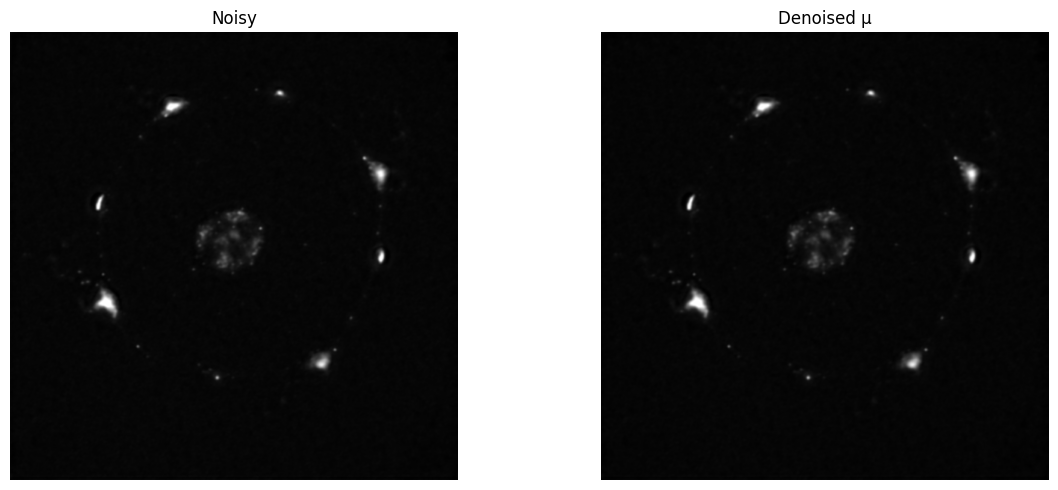


⬆️  Upload *clean* reference for PSNR / SSIM / MSE (or skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309 (2).tif
✓ clean loaded: slice&#x3a_3309 (2).tif

📊  Metrics vs. clean reference
    • MSE  : 0.000176
    • PSNR : 37.55 dB
    • SSIM : 0.8972


In [ ]:
# ============================================================
#  Probabilistic Noise2Void‑2 (Variant 4) – Single‑Image Demo
#  • per‑pixel μ + log σ², clamped for stability
#  • longer training + proper display scaling
#  • OPTIONAL PSNR / SSIM / MSE
#  • NEW → saves μ as PNG (8‑bit)  +  σ as TIFF (float32)
# ============================================================

# 0 ▸ install extras ----------------------------------------------------
!pip -q install tifffile scikit-image
import tifffile, imageio, os, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim
from google.colab import files

# 1 ▸ imports & device --------------------------------------------------
import matplotlib.pyplot as plt, torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# 2 ▸ upload NOISY image -----------------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]          # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("image shape:", noisy_np.shape)

# 3 ▸ random‑patch dataset ---------------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=24000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8, shuffle=True,
                      num_workers=2, pin_memory=True)

# 4 ▸ centre‑pixel mask -------------------------------------------------
def mask_center(x, p=0.04):
    m   = torch.rand_like(x) < p
    shifts = [(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    idx = torch.randint(0, len(shifts), (x.size(0),1,x.size(2),x.size(3)), device=x.device)
    nb  = torch.zeros_like(x)
    for k,(dy,dx) in enumerate(shifts):
        nbk = torch.roll(x, (dy,dx), dims=(-2,-1))
        nb[idx==k] = nbk[idx==k]
    x_m = x.clone(); x_m[m] = nb[m]
    return x_m, m

# 5 ▸ probabilistic U‑Net ----------------------------------------------
class ConvBlk(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.LeakyReLU(0.1,True),
            nn.Conv2d(c2,c2,3,padding=1), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class ProbUNet(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = ConvBlk(in_ch,base), ConvBlk(base,base*2), ConvBlk(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = ConvBlk(base*4+base*2,base*2), ConvBlk(base*2+base,base)
        self.out = nn.Conv2d(base, 2, 1)   # → μ, log σ²
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = ProbUNet().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# 6 ▸ masked Gaussian NLL ----------------------------------------------
def gaussian_nll(mu, logvar, target, mask, lo=-5., hi=4.):
    logvar = logvar.clamp(lo, hi)
    invvar = torch.exp(-logvar)
    nll = 0.5*((target-mu)**2 * invvar + logvar)
    return nll[mask].mean()

# 7 ▸ training ----------------------------------------------------------
epochs, lr = 10, 5e-4
opt  = optim.Adam(net.parameters(), lr=lr)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); run=0
    for xb in train_dl:
        xb = xb.to(device)
        xin, m = mask_center(xb, p=0.04)
        mu_logv = net(xin)
        mu, logv = mu_logv[:,0:1], mu_logv[:,1:2]
        loss = gaussian_nll(mu, logv, xb, m)
        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | masked‑NLL={run/len(train_dl.dataset):.5f}")

# 8 ▸ inference ---------------------------------------------------------
net.eval()
with torch.no_grad():
    out = net(torch.from_numpy(noisy_np).unsqueeze(0).to(device))
    mu    = np.clip(out[:,0:1].cpu().squeeze().numpy(), 0, 1)
    sigma = np.clip(torch.exp(0.5*out[:,1:2]).cpu().squeeze().numpy(), 1e-3, None)

# 9 ▸ save outputs ------------------------------------------------------
# save μ as 8‑bit PNG
mu_png = (mu*255).astype(np.uint8)
png_name = os.path.splitext(noisy_fname)[0] + "_denoised.png"
imageio.imwrite(png_name, mu_png)
print(f"μ saved → {png_name}")
files.download(png_name)

# 10 ▸ show results -----------------------------------------------------
plt.figure(figsize=(18,5))
plt.subplot(1,3,1); plt.imshow(noisy_np.squeeze(), cmap='gray', vmin=0, vmax=1); plt.title("Noisy");           plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mu,               cmap='gray',  vmin=0, vmax=1); plt.title("Denoised μ");      plt.axis('off')
plt.tight_layout(); plt.show()

# 11 ▸ OPTIONAL: metrics block (unchanged) ------------------------------
print("\n⬆️  Upload *clean* reference for PSNR / SSIM / MSE (or skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()

    if clean_np.shape != mu.shape:
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=mu.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()

    mse_val  = np.mean((mu - clean_np)**2)
    psnr_val = psnr(clean_np, mu, data_range=1.0)
    ssim_val = ssim(clean_np, mu, data_range=1.0)

    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference supplied → metrics skipped.")


Probabilistic N2V – 3rd Denoising Pass
This run represents the third pass of denoising using Probabilistic Noise2Void. A new model is trained on the twice-denoised image, allowing it to refine the image further and correct subtle residual artifacts that survived previous passes.

▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise_Prob_denoised (2)_denoised.png to slice&#x3a_3309_gaussian_noise_Prob_denoised (2)_denoised (1).png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise_Prob_denoised (2)_denoised (1).png
image shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | masked‑NLL=-2.43544
epoch 10/10 | masked‑NLL=-2.49968
μ saved → slice&#x3a_3309_gaussian_noise_Prob_denoised (2)_denoised (1)_denoised.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

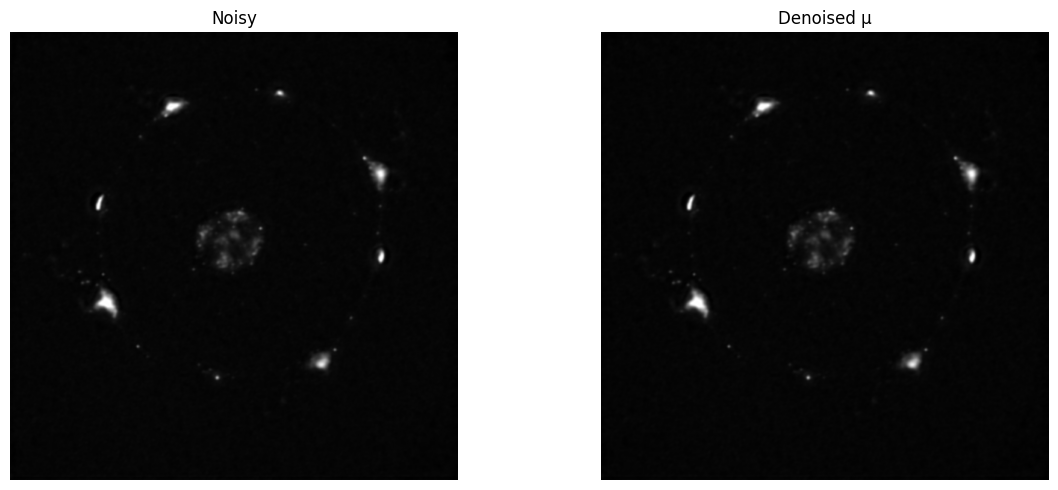


⬆️  Upload *clean* reference for PSNR / SSIM / MSE (or skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309 (3).tif
✓ clean loaded: slice&#x3a_3309 (3).tif

📊  Metrics vs. clean reference
    • MSE  : 0.000149
    • PSNR : 38.27 dB
    • SSIM : 0.9201


In [ ]:
# ============================================================
#  Probabilistic Noise2Void‑2 (Variant 4) – Single‑Image Demo
#  • per‑pixel μ + log σ², clamped for stability
#  • longer training + proper display scaling
#  • OPTIONAL PSNR / SSIM / MSE
#  • NEW → saves μ as PNG (8‑bit)  +  σ as TIFF (float32)
# ============================================================

# 0 ▸ install extras ----------------------------------------------------
!pip -q install tifffile scikit-image
import tifffile, imageio, os, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim
from google.colab import files

# 1 ▸ imports & device --------------------------------------------------
import matplotlib.pyplot as plt, torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# 2 ▸ upload NOISY image -----------------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]          # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("image shape:", noisy_np.shape)

# 3 ▸ random‑patch dataset ---------------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=24000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8, shuffle=True,
                      num_workers=2, pin_memory=True)

# 4 ▸ centre‑pixel mask -------------------------------------------------
def mask_center(x, p=0.04):
    m   = torch.rand_like(x) < p
    shifts = [(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    idx = torch.randint(0, len(shifts), (x.size(0),1,x.size(2),x.size(3)), device=x.device)
    nb  = torch.zeros_like(x)
    for k,(dy,dx) in enumerate(shifts):
        nbk = torch.roll(x, (dy,dx), dims=(-2,-1))
        nb[idx==k] = nbk[idx==k]
    x_m = x.clone(); x_m[m] = nb[m]
    return x_m, m

# 5 ▸ probabilistic U‑Net ----------------------------------------------
class ConvBlk(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.LeakyReLU(0.1,True),
            nn.Conv2d(c2,c2,3,padding=1), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class ProbUNet(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = ConvBlk(in_ch,base), ConvBlk(base,base*2), ConvBlk(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = ConvBlk(base*4+base*2,base*2), ConvBlk(base*2+base,base)
        self.out = nn.Conv2d(base, 2, 1)   # → μ, log σ²
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = ProbUNet().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# 6 ▸ masked Gaussian NLL ----------------------------------------------
def gaussian_nll(mu, logvar, target, mask, lo=-5., hi=4.):
    logvar = logvar.clamp(lo, hi)
    invvar = torch.exp(-logvar)
    nll = 0.5*((target-mu)**2 * invvar + logvar)
    return nll[mask].mean()

# 7 ▸ training ----------------------------------------------------------
epochs, lr = 10, 5e-4
opt  = optim.Adam(net.parameters(), lr=lr)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); run=0
    for xb in train_dl:
        xb = xb.to(device)
        xin, m = mask_center(xb, p=0.04)
        mu_logv = net(xin)
        mu, logv = mu_logv[:,0:1], mu_logv[:,1:2]
        loss = gaussian_nll(mu, logv, xb, m)
        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | masked‑NLL={run/len(train_dl.dataset):.5f}")

# 8 ▸ inference ---------------------------------------------------------
net.eval()
with torch.no_grad():
    out = net(torch.from_numpy(noisy_np).unsqueeze(0).to(device))
    mu    = np.clip(out[:,0:1].cpu().squeeze().numpy(), 0, 1)
    sigma = np.clip(torch.exp(0.5*out[:,1:2]).cpu().squeeze().numpy(), 1e-3, None)

# 9 ▸ save outputs ------------------------------------------------------
# save μ as 8‑bit PNG
mu_png = (mu*255).astype(np.uint8)
png_name = os.path.splitext(noisy_fname)[0] + "_denoised.png"
imageio.imwrite(png_name, mu_png)
print(f"μ saved → {png_name}")
files.download(png_name)

# 10 ▸ show results -----------------------------------------------------
plt.figure(figsize=(18,5))
plt.subplot(1,3,1); plt.imshow(noisy_np.squeeze(), cmap='gray', vmin=0, vmax=1); plt.title("Noisy");           plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mu,               cmap='gray',  vmin=0, vmax=1); plt.title("Denoised μ");      plt.axis('off')
plt.tight_layout(); plt.show()

# 11 ▸ OPTIONAL: metrics block (unchanged) ------------------------------
print("\n⬆️  Upload *clean* reference for PSNR / SSIM / MSE (or skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()

    if clean_np.shape != mu.shape:
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=mu.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()

    mse_val  = np.mean((mu - clean_np)**2)
    psnr_val = psnr(clean_np, mu, data_range=1.0)
    ssim_val = ssim(clean_np, mu, data_range=1.0)

    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference supplied → metrics skipped.")


Structured → Probabilistic N2V Cascade Pass
This script performs a Probabilistic Noise2Void (PN2V) denoising run on an image that has already been denoised once using Structured Noise2Void (Structured N2V). This cascading approach leverages the strengths of both models to refine image quality further.



▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise_denoised.png to slice&#x3a_3309_gaussian_noise_denoised.png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise_denoised.png
image shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | masked‑NLL=-2.43901
epoch 10/10 | masked‑NLL=-2.49953
μ saved → slice&#x3a_3309_gaussian_noise_denoised_denoised.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

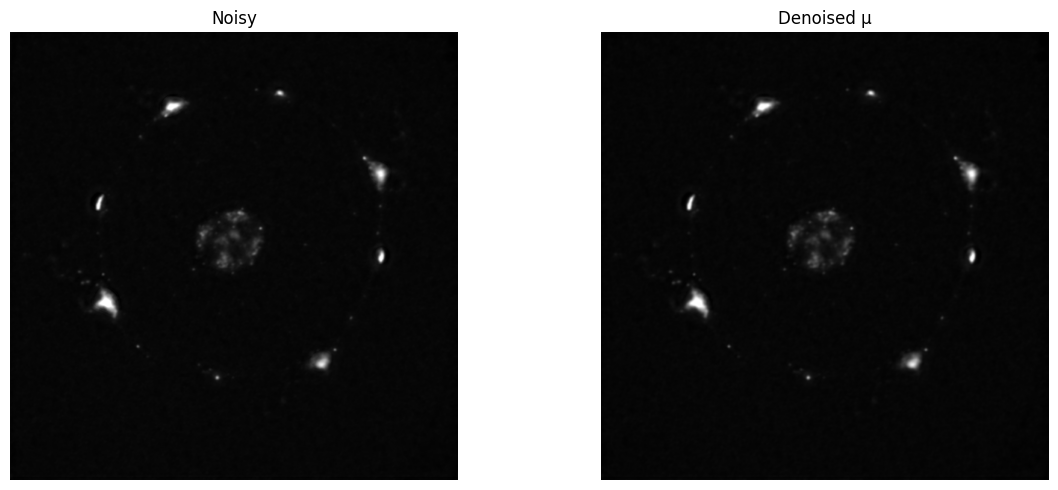


⬆️  Upload *clean* reference for PSNR / SSIM / MSE (or skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309.tif
✓ clean loaded: slice&#x3a_3309.tif

📊  Metrics vs. clean reference
    • MSE  : 0.000210
    • PSNR : 36.78 dB
    • SSIM : 0.8724


In [ ]:
# ============================================================
#  Probabilistic Noise2Void‑2 (Variant 4) – Single‑Image Demo
#  • per‑pixel μ + log σ², clamped for stability
#  • longer training + proper display scaling
#  • OPTIONAL PSNR / SSIM / MSE
#  • NEW → saves μ as PNG (8‑bit)  +  σ as TIFF (float32)
# ============================================================

# 0 ▸ install extras ----------------------------------------------------
!pip -q install tifffile scikit-image
import tifffile, imageio, os, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim
from google.colab import files

# 1 ▸ imports & device --------------------------------------------------
import matplotlib.pyplot as plt, torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# 2 ▸ upload NOISY image -----------------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]          # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("image shape:", noisy_np.shape)

# 3 ▸ random‑patch dataset ---------------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=24000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8, shuffle=True,
                      num_workers=2, pin_memory=True)

# 4 ▸ centre‑pixel mask -------------------------------------------------
def mask_center(x, p=0.04):
    m   = torch.rand_like(x) < p
    shifts = [(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    idx = torch.randint(0, len(shifts), (x.size(0),1,x.size(2),x.size(3)), device=x.device)
    nb  = torch.zeros_like(x)
    for k,(dy,dx) in enumerate(shifts):
        nbk = torch.roll(x, (dy,dx), dims=(-2,-1))
        nb[idx==k] = nbk[idx==k]
    x_m = x.clone(); x_m[m] = nb[m]
    return x_m, m

# 5 ▸ probabilistic U‑Net ----------------------------------------------
class ConvBlk(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.LeakyReLU(0.1,True),
            nn.Conv2d(c2,c2,3,padding=1), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class ProbUNet(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = ConvBlk(in_ch,base), ConvBlk(base,base*2), ConvBlk(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = ConvBlk(base*4+base*2,base*2), ConvBlk(base*2+base,base)
        self.out = nn.Conv2d(base, 2, 1)   # → μ, log σ²
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = ProbUNet().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# 6 ▸ masked Gaussian NLL ----------------------------------------------
def gaussian_nll(mu, logvar, target, mask, lo=-5., hi=4.):
    logvar = logvar.clamp(lo, hi)
    invvar = torch.exp(-logvar)
    nll = 0.5*((target-mu)**2 * invvar + logvar)
    return nll[mask].mean()

# 7 ▸ training ----------------------------------------------------------
epochs, lr = 10, 5e-4
opt  = optim.Adam(net.parameters(), lr=lr)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); run=0
    for xb in train_dl:
        xb = xb.to(device)
        xin, m = mask_center(xb, p=0.04)
        mu_logv = net(xin)
        mu, logv = mu_logv[:,0:1], mu_logv[:,1:2]
        loss = gaussian_nll(mu, logv, xb, m)
        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | masked‑NLL={run/len(train_dl.dataset):.5f}")

# 8 ▸ inference ---------------------------------------------------------
net.eval()
with torch.no_grad():
    out = net(torch.from_numpy(noisy_np).unsqueeze(0).to(device))
    mu    = np.clip(out[:,0:1].cpu().squeeze().numpy(), 0, 1)
    sigma = np.clip(torch.exp(0.5*out[:,1:2]).cpu().squeeze().numpy(), 1e-3, None)

# 9 ▸ save outputs ------------------------------------------------------
# save μ as 8‑bit PNG
mu_png = (mu*255).astype(np.uint8)
png_name = os.path.splitext(noisy_fname)[0] + "_denoised.png"
imageio.imwrite(png_name, mu_png)
print(f"μ saved → {png_name}")
files.download(png_name)

# 10 ▸ show results -----------------------------------------------------
plt.figure(figsize=(18,5))
plt.subplot(1,3,1); plt.imshow(noisy_np.squeeze(), cmap='gray', vmin=0, vmax=1); plt.title("Noisy");           plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mu,               cmap='gray',  vmin=0, vmax=1); plt.title("Denoised μ");      plt.axis('off')
plt.tight_layout(); plt.show()

# 11 ▸ OPTIONAL: metrics block (unchanged) ------------------------------
print("\n⬆️  Upload *clean* reference for PSNR / SSIM / MSE (or skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()

    if clean_np.shape != mu.shape:
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=mu.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()

    mse_val  = np.mean((mu - clean_np)**2)
    psnr_val = psnr(clean_np, mu, data_range=1.0)
    ssim_val = ssim(clean_np, mu, data_range=1.0)

    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference supplied → metrics skipped.")


Probabilistic → Structured N2V Cascade Pass
This script applies Structured Noise2Void (Variant 3) to a previously denoised image produced by Probabilistic Noise2Void (Variant 4). This cascade takes advantage of the uncertainty-aware predictions from PN2V, followed by structured grid-based refinement to clean residual errors.

▶️  device: cuda

⬆️  Upload your *noisy* image (tif / png / jpg)…


Saving slice&#x3a_3309_gaussian_noise_Prob_denoised.png to slice&#x3a_3309_gaussian_noise_Prob_denoised.png
✓ noisy loaded: slice&#x3a_3309_gaussian_noise_Prob_denoised.png
image shape: (1, 600, 600)
params: 0.47 M
epoch  1/10 | loss=0.00418
epoch 10/10 | loss=0.00000
denoised saved → slice&#x3a_3309_gaussian_noise_Prob_denoised_denoised.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mask saved → slice&#x3a_3309_gaussian_noise_Prob_denoised_gridmask.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

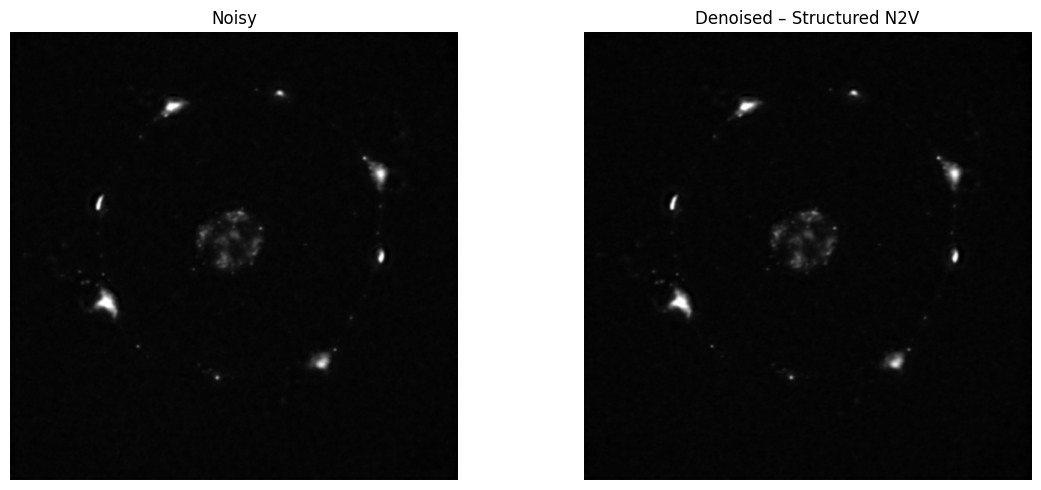


⬆️  Upload *clean* image for PSNR / SSIM / MSE (or skip)…


Saving slice&#x3a_3309.tif to slice&#x3a_3309.tif
✓ clean loaded: slice&#x3a_3309.tif

📊  Metrics vs. clean reference
    • MSE  : 0.000181
    • PSNR : 37.43 dB
    • SSIM : 0.8968


In [ ]:
# ============================================================
#  Noise2Void Variant 3 – Structured/Grid‑Mask Self‑Supervised
#  ▸ bug‑fixed grid mask
#  ▸ 40 epochs, step = 5
#  ▸ Saves denoised PNG  +  full‑image grid mask TIFF
#  ▸ Optional PSNR / SSIM / MSE against a clean image
# ============================================================

# 0 ▸ install dependencies -----------------------------------
!pip -q install tifffile scikit-image imageio
import tifffile, imageio, os, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim
from google.colab import files

# 1 ▸ imports & device --------------------------------------
import matplotlib.pyplot as plt, torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("▶️  device:", device)

# 2 ▸ upload noisy image ------------------------------------
print("\n⬆️  Upload your *noisy* image (tif / png / jpg)…")
noisy_fname = next(iter(files.upload()))
print("✓ noisy loaded:", noisy_fname)

def load_gray(path):
    if path.lower().endswith(('.tif', '.tiff')):
        img = tifffile.imread(path)
    else:
        img = np.array(Image.open(path).convert('L'))
    img = img.astype(np.float32)
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    return img[np.newaxis]          # (1,H,W)

noisy_np = load_gray(noisy_fname)
print("image shape:", noisy_np.shape)

# 3 ▸ patch dataset -----------------------------------------
class PatchDS(Dataset):
    def __init__(self, img, ps=64, n=40000):
        self.img, self.ps, self.n = torch.from_numpy(img), ps, n
    def __len__(self):  return self.n
    def __getitem__(self, _):
        y = np.random.randint(0, self.img.shape[-2]-self.ps+1)
        x = np.random.randint(0, self.img.shape[-1]-self.ps+1)
        return self.img[:, y:y+self.ps, x:x+self.ps].clone()

train_dl = DataLoader(PatchDS(noisy_np), batch_size=8, shuffle=True,
                      num_workers=2, pin_memory=True)

# 4 ▸ grid‑mask helper --------------------------------------
def grid_mask(x, step=5):
    """
    x : (B,C,H,W) tensor
    returns masked_x, mask  (mask is boolean)
    """
    B,C,H,W = x.shape
    off_y = torch.randint(0, step, (B,1,1,1), device=x.device)
    off_x = torch.randint(0, step, (B,1,1,1), device=x.device)
    ys = (torch.arange(H, device=x.device)[None,None,:,None] + off_y) % step == 0
    xs = (torch.arange(W, device=x.device)[None,None,None,:] + off_x) % step == 0
    mask = ys & xs                                    # (B,1,H,W)
    nb   = torch.roll(x, (1,0), (-2,-1))
    x_m  = x.clone(); x_m[mask] = nb[mask]
    return x_m, mask

# 5 ▸ lightweight U‑Net -------------------------------------
class ConvBlk(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.LeakyReLU(0.1,True),
            nn.Conv2d(c2,c2,3,padding=1), nn.LeakyReLU(0.1,True))
    def forward(self,x): return self.seq(x)

class UNetSmall(nn.Module):
    def __init__(self, ch=1, base=32):
        super().__init__()
        self.e1,self.e2,self.e3 = ConvBlk(ch,base), ConvBlk(base,base*2), ConvBlk(base*2,base*4)
        self.pool = nn.MaxPool2d(2)
        self.d2,self.d1 = ConvBlk(base*4+base*2,base*2), ConvBlk(base*2+base,base)
        self.out = nn.Conv2d(base, ch, 1)
    def forward(self,x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        u2 = F.interpolate(e3, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.d2(torch.cat([u2, e2],1))
        u1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.d1(torch.cat([u1, e1],1))
        return self.out(d1)

net = UNetSmall().to(device)
print("params: %.2f M" % (sum(p.numel() for p in net.parameters())/1e6))

# 6 ▸ training ----------------------------------------------
epochs, lr, step = 10, 1e-3, 5
opt = optim.Adam(net.parameters(), lr=lr)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

for ep in range(1, epochs+1):
    net.train(); run=0
    for xb in train_dl:
        xb = xb.to(device)
        xin, m = grid_mask(xb, step=step)
        loss = F.mse_loss(net(xin)[m], xb[m])
        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    sched.step()
    if ep==1 or ep%10==0:
        print(f"epoch {ep:2d}/{epochs} | loss={run/len(train_dl.dataset):.5f}")

# 7 ▸ denoise full image ------------------------------------
net.eval()
with torch.no_grad():
    den = net(torch.from_numpy(noisy_np).unsqueeze(0).to(device)).cpu().squeeze().numpy()
    den = np.clip(den, 0, 1)

# 8 ▸ save outputs ------------------------------------------
out_png = os.path.splitext(noisy_fname)[0] + "_denoised.png"
imageio.imwrite(out_png, (den*255).astype(np.uint8))
print(f"denoised saved → {out_png}")
files.download(out_png)

# full‑image checkerboard mask
_, full_mask = grid_mask(torch.from_numpy(noisy_np).unsqueeze(0), step=step)
mask_tif = os.path.splitext(noisy_fname)[0] + "_gridmask.tif"
tifffile.imwrite(mask_tif, full_mask.squeeze().numpy().astype(np.uint8))
print(f"mask saved → {mask_tif}")
files.download(mask_tif)

# 9 ▸ display ------------------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(noisy_np.squeeze(), cmap='gray', vmin=0, vmax=1); plt.title("Noisy");   plt.axis('off')
plt.subplot(1,2,2); plt.imshow(den,            cmap='gray', vmin=0, vmax=1); plt.title("Denoised – Structured N2V"); plt.axis('off')
plt.tight_layout(); plt.show()

# 10 ▸ optional metrics -------------------------------------
print("\n⬆️  Upload *clean* image for PSNR / SSIM / MSE (or skip)…")
try:
    clean_fname = next(iter(files.upload()))
except StopIteration:
    clean_fname = None

if clean_fname:
    print("✓ clean loaded:", clean_fname)
    clean_np = load_gray(clean_fname).squeeze()
    if clean_np.shape != den.shape:
        clean_np = F.interpolate(torch.tensor(clean_np)[None,None].to(device),
                                 size=den.shape, mode='bilinear',
                                 align_corners=False).cpu().squeeze().numpy()
    mse_val  = np.mean((den - clean_np)**2)
    psnr_val = psnr(clean_np, den, data_range=1.0)
    ssim_val = ssim(clean_np, den, data_range=1.0)
    print("\n📊  Metrics vs. clean reference")
    print(f"    • MSE  : {mse_val:0.6f}")
    print(f"    • PSNR : {psnr_val:0.2f} dB")
    print(f"    • SSIM : {ssim_val:0.4f}")
else:
    print("No clean reference supplied → metrics skipped.")
